<a href="https://colab.research.google.com/github/hoangcuongnguyen2001/Honours_Repository/blob/main/Fine_tune_SciBERT_for_new_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SciBERT for Single-Label Classification

[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/center-for-threat-informed-defense/tram/blob/main/user_notebooks/fine_tune_single_label.ipynb)

This notebook allows one to continue fine-tuning our provided SciBERT-for-singlelabel-sequence-classification on custom data.

In [ ]:
!mkdir scibert_single_label_model
!wget https://ctidtram.blob.core.windows.net/tram-models/single-label-202308303/config.json -O scibert_single_label_model/config.json
!wget https://ctidtram.blob.core.windows.net/tram-models/single-label-202308303/pytorch_model.bin -O scibert_single_label_model/pytorch_model.bin
!pip install torch transformers pandas

--2023-10-01 21:56:23--  https://ctidtram.blob.core.windows.net/tram-models/single-label-202308303/config.json
Resolving ctidtram.blob.core.windows.net (ctidtram.blob.core.windows.net)... 52.239.246.4
Connecting to ctidtram.blob.core.windows.net (ctidtram.blob.core.windows.net)|52.239.246.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2806 (2.7K) [application/json]
Saving to: ‘scibert_single_label_model/config.json’

scibert_single_labe 100%[===================>]   2.74K  --.-KB/s    in 0s      

2023-10-01 21:56:24 (1.38 GB/s) - ‘scibert_single_label_model/config.json’ saved [2806/2806]

--2023-10-01 21:56:24--  https://ctidtram.blob.core.windows.net/tram-models/single-label-202308303/pytorch_model.bin
Resolving ctidtram.blob.core.windows.net (ctidtram.blob.core.windows.net)... 52.239.246.4
Connecting to ctidtram.blob.core.windows.net (ctidtram.blob.core.windows.net)|52.239.246.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 439

This cell instantiates the label encoder. Do not modify this cell, as the classes (ie, ATT&CK techniques) and their order must match those the model expects.

In [ ]:
from sklearn.preprocessing import OneHotEncoder as OHE

CLASSES = [
   'T1003.001', 'T1005', 'T1012', 'T1016', 'T1021.001', 'T1027',
   'T1033', 'T1036.005', 'T1041', 'T1047', 'T1053.005', 'T1055',
   'T1056.001', 'T1057', 'T1059.003', 'T1068', 'T1070.004',
   'T1071.001', 'T1072', 'T1074.001', 'T1078', 'T1082', 'T1083',
   'T1090', 'T1095', 'T1105', 'T1106', 'T1110', 'T1112', 'T1113',
   'T1140', 'T1190', 'T1204.002', 'T1210', 'T1218.011', 'T1219',
   'T1484.001', 'T1518.001', 'T1543.003', 'T1547.001', 'T1548.002',
   'T1552.001', 'T1557.001', 'T1562.001', 'T1564.001', 'T1566.001',
   'T1569.002', 'T1570', 'T1573.001', 'T1574.002'
]

encoder = OHE(sparse_output=False)
encoder.fit([[c] for c in CLASSES])

encoder.categories_

[array(['T1003.001', 'T1005', 'T1012', 'T1016', 'T1021.001', 'T1027',
        'T1033', 'T1036.005', 'T1041', 'T1047', 'T1053.005', 'T1055',
        'T1056.001', 'T1057', 'T1059.003', 'T1068', 'T1070.004',
        'T1071.001', 'T1072', 'T1074.001', 'T1078', 'T1082', 'T1083',
        'T1090', 'T1095', 'T1105', 'T1106', 'T1110', 'T1112', 'T1113',
        'T1140', 'T1190', 'T1204.002', 'T1210', 'T1218.011', 'T1219',
        'T1484.001', 'T1518.001', 'T1543.003', 'T1547.001', 'T1548.002',
        'T1552.001', 'T1557.001', 'T1562.001', 'T1564.001', 'T1566.001',
        'T1569.002', 'T1570', 'T1573.001', 'T1574.002'], dtype=object)]

In [ ]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:

#Upload the JSON file for fine-tuning (from cti-to-mitre-with-nlp)
import gdown

url = 'https://drive.google.com/file/d/1BCkEdKgmH49kjihmrxlXVUQvB0GsiQJW/view?usp=drive_link'
output_path = 'TRAM_fine_tuned_SciBERT.json'
gdown.download(url, output_path, quiet=False,fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1BCkEdKgmH49kjihmrxlXVUQvB0GsiQJW
To: /content/TRAM_fine_tuned_SciBERT.json
100%|██████████| 1.38M/1.38M [00:00<00:00, 162MB/s]


'TRAM_fine_tuned_SciBERT.json'

This cell is for loading the training data. You will need to modify this cell to load your data. Ensure that by the end of this cell, a DataFrame has been assigned to the variable `data` that has a `text` column containing the segments, and a `label` column containing individual strings, where those strings are an ATT&CK IDs that this model can classify. It does not matter how the DataFrame is indexed or what other columns with other names, if any, it has.

For demonstration purposes, we will use the same single-label data that was produced during this TRAM effort, even though the model was trained on this data already. This cell is only present to show the expected format of the `data` DataFrame, and is not intended to be run as shown.

In [ ]:
import pandas as pd
data = pd.read_json('TRAM_fine_tuned_SciBERT.json')
data

,text,label
0,Anchor has used cmd.exe to run its self deleti...,T1059.003
1,Zeus Panda can launch an interface where it ca...,T1059.003
2,Chimera has used the Windows Command Shell and...,T1059.003
3,Cuba has used cmd.exe /c and batch files for e...,T1059.003
4,MechaFlounder has the ability to run commands ...,T1059.003
...,...,...
9806,Kazuar can delete files.,T1070.004
9807,Cobalt Strike can exploit vulnerabilities such...,T1068
9808,QakBot can send stolen information to C2 nodes...,T1041
9809,Turla RPC backdoors have also searched for fil...,T1083


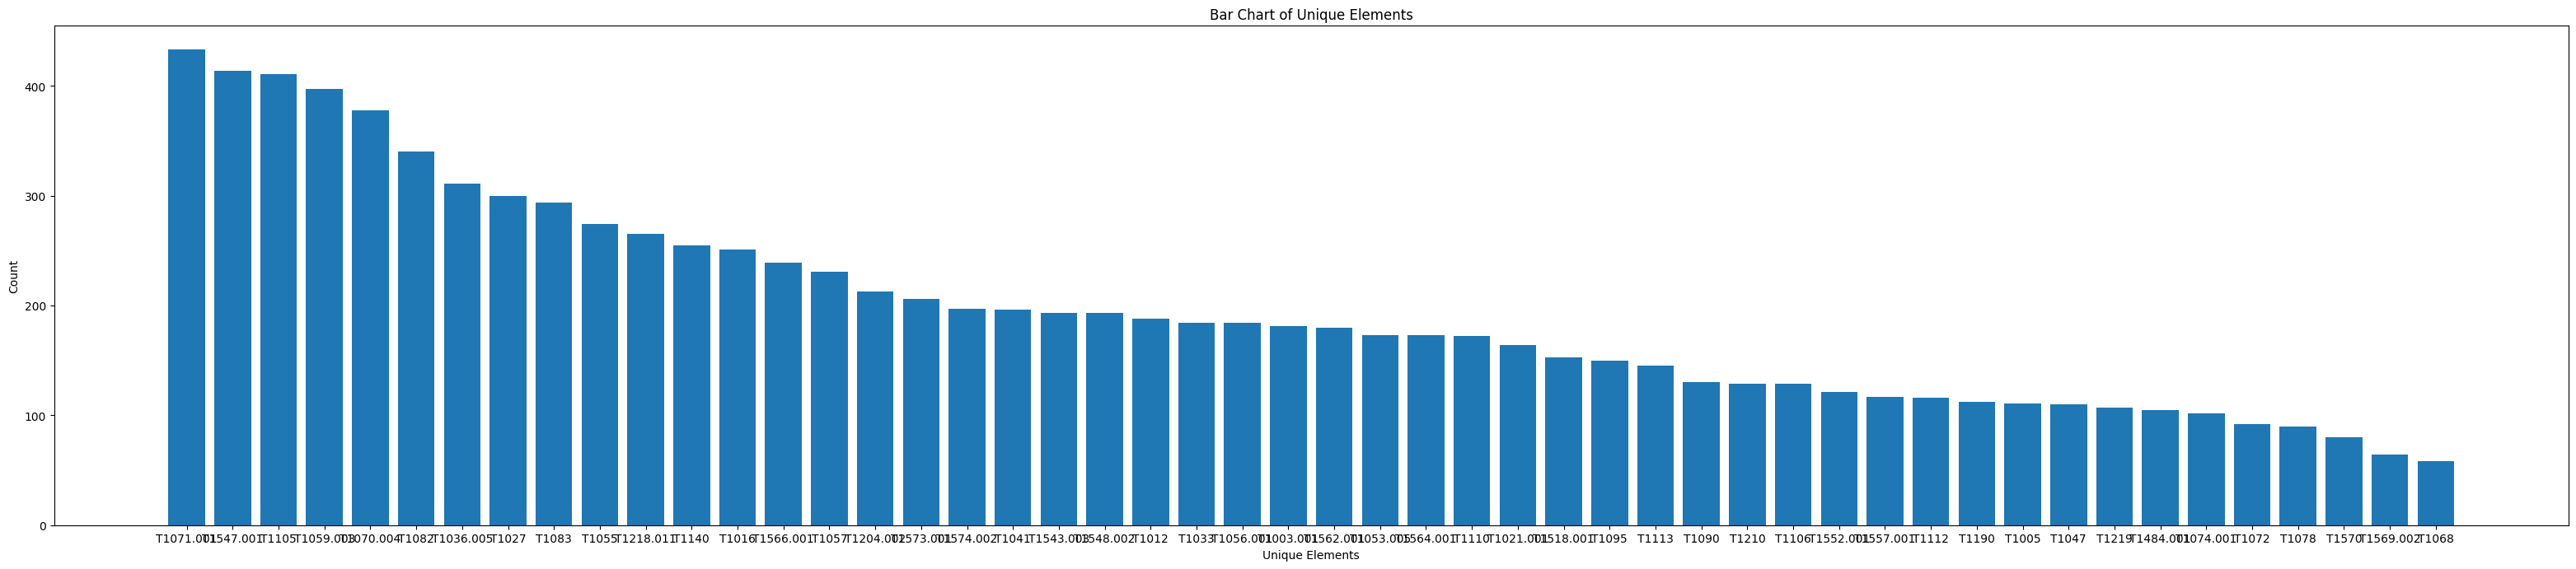

In [ ]:
import matplotlib.pyplot as plt

unique_elements = data['label'].value_counts()
unique_elements_list = unique_elements.reset_index().values.tolist()

def cm_to_inch(value):
    return value/2.54


plt.figure(figsize=(cm_to_inch(100), cm_to_inch(20)))
plt.bar(unique_elements.index, unique_elements.values)
plt.xlabel('Unique Elements')
plt.ylabel('Count')
plt.title('Bar Chart of Unique Elements')
plt.show()

In [ ]:
unique_elements_amount = unique_elements.reset_index().values
print(unique_elements_amount)

[['T1071.001' 433]
 ['T1547.001' 414]
 ['T1105' 411]
 ['T1059.003' 397]
 ['T1070.004' 378]
 ['T1082' 340]
 ['T1036.005' 311]
 ['T1027' 300]
 ['T1083' 294]
 ['T1055' 274]
 ['T1218.011' 265]
 ['T1140' 255]
 ['T1016' 251]
 ['T1566.001' 239]
 ['T1057' 231]
 ['T1204.002' 213]
 ['T1573.001' 206]
 ['T1574.002' 197]
 ['T1041' 196]
 ['T1543.003' 193]
 ['T1548.002' 193]
 ['T1012' 188]
 ['T1033' 184]
 ['T1056.001' 184]
 ['T1003.001' 181]
 ['T1562.001' 180]
 ['T1053.005' 173]
 ['T1564.001' 173]
 ['T1110' 172]
 ['T1021.001' 164]
 ['T1518.001' 153]
 ['T1095' 150]
 ['T1113' 145]
 ['T1090' 130]
 ['T1210' 129]
 ['T1106' 129]
 ['T1552.001' 121]
 ['T1557.001' 117]
 ['T1112' 116]
 ['T1190' 112]
 ['T1005' 111]
 ['T1047' 110]
 ['T1219' 107]
 ['T1484.001' 105]
 ['T1074.001' 102]
 ['T1072' 92]
 ['T1078' 90]
 ['T1570' 80]
 ['T1569.002' 64]
 ['T1068' 58]]


In [ ]:
import transformers
import torch

cuda = torch.device('cuda')

tokenizer = transformers.BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", max_length=512)
bert = transformers.BertForSequenceClassification.from_pretrained('scibert_single_label_model').to(cuda).train()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, shuffle=True)

def _load_data(x, y, batch_size=10):
    x_len, y_len = x.shape[0], y.shape[0]
    assert x_len == y_len
    for i in range(0, x_len, batch_size):
        slc = slice(i, i + batch_size)
        yield x[slc].to(cuda), y[slc].to(cuda)

def _tokenize(instances: list[str]):
    return tokenizer(instances, return_tensors='pt', padding='max_length', truncation=True, max_length=512).input_ids

def _encode_labels(labels):
    """:labels: should be the `labels` column (a Series) of the DataFrame"""
    return torch.Tensor(encoder.transform(labels))

In [ ]:
x_train = _tokenize(train['text'].tolist())
x_train

tensor([[  102,  1059,  2085,  ...,     0,     0,     0],
        [  102,  3996,   198,  ...,     0,     0,     0],
        [  102,  4011,  3054,  ...,     0,     0,     0],
        ...,
        [  102, 22064,   434,  ...,     0,     0,     0],
        [  102, 16126, 22764,  ...,     0,     0,     0],
        [  102, 20299,  6065,  ...,     0,     0,     0]])

In [ ]:
y_train = _encode_labels(train[['label']])
y_train

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
y_test = _encode_labels(test[['label']])
y_test

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
y_train.size(dim=1)

50

This array may appear to be empty, but taking the sum shows that there is one `1` per row.

In [ ]:
y_train.sum()

tensor(7848.)

In [ ]:
import torch
import torch.nn as nn

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, y_pred, y_true):
        squared_errors = torch.square(y_pred - y_true)
        weighted_squared_errors = squared_errors * self.weights.unsqueeze(1)
        loss = torch.mean(weighted_squared_errors)
        return loss

This cell contains the training loop. You may change the `NUM_EPOCHS` value to any integer you would like.

In [ ]:
NUM_EPOCHS = 6

from statistics import mean

from tqdm import tqdm
from torch.optim import AdamW

optim = AdamW(bert.parameters(), lr=2e-5, eps=1e-8)

for epoch in range(NUM_EPOCHS):
    epoch_losses = []
    for x, y in tqdm(_load_data(x_train, y_train, batch_size=10)):
        bert.zero_grad()
        out = bert(x, attention_mask=x.ne(tokenizer.pad_token_id).to(int), labels=y)
        epoch_losses.append(out.loss.item())
        out.loss.backward()
        optim.step()
    print(f"epoch {epoch + 1} loss: {mean(epoch_losses)}")

785it [11:39,  1.12it/s]


epoch 1 loss: 0.026802383037877214


785it [11:38,  1.12it/s]


epoch 2 loss: 0.01586254457053343


785it [11:38,  1.12it/s]


epoch 3 loss: 0.009922195185171618


785it [11:37,  1.12it/s]


epoch 4 loss: 0.006487768248115091


785it [11:38,  1.12it/s]


epoch 5 loss: 0.004888258683109644


785it [11:38,  1.12it/s]

epoch 6 loss: 0.004141906665854607


If the loss from the last iteration was not to your liking, do not re-run the previous cell. Uncomment the following cell and run it for however many additional epochs you would like.

In [ ]:
# NUM_EXTRA_EPOCHS = 1
# for epoch in range(NUM_EXTRA_EPOCHS):
#     epoch_losses = []
#     for x, y in tqdm(_load_data(x_train, y_train, batch_size=10)):
#         bert.zero_grad()
#         out = bert(x, attention_mask=x.ne(tokenizer.pad_token_id).to(int), labels=y)
#         epoch_losses.append(out.loss.item())
#         out.loss.backward()
#         optim.step()
#     print(f"epoch {epoch + 1} loss: {mean(epoch_losses)}")

The next cells evaluate the performance after the additional fine-tuning. The
performance scores on the example data will be high, as the model has already been trained on most of these instances.

In [ ]:
bert.eval()

x_test = _tokenize(test['text'].tolist())
y_test = test['label']

batch_size = 20
preds = []

with torch.no_grad():
    for i in range(0, x_test.shape[0], batch_size):
        x = x_test[i : i + batch_size].to(cuda)
        out = bert(x, attention_mask=x.ne(tokenizer.pad_token_id).to(int))
        preds.extend(out.logits.to('cpu'))

import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support as calculate_score

predicted_labels = (
    encoder.inverse_transform(
        F.one_hot(
            torch.vstack(preds).softmax(-1).argmax(-1),
            num_classes=len(encoder.categories_[0])
        )
        .numpy()
    )
    .reshape(-1)
)

predicted = list(predicted_labels)
actual = y_test.tolist()

labels = sorted(set(actual) | set(predicted))

scores = calculate_score(actual, predicted, labels=labels)

scores_df = pd.DataFrame(scores).T
scores_df.columns = ['P', 'R', 'F1', '#']
scores_df.index = labels
scores_df.loc['(micro)'] = calculate_score(actual, predicted, average='micro', labels=labels)
scores_df.loc['(macro)'] = calculate_score(actual, predicted, average='macro', labels=labels)

scores_df

,P,R,F1,#
T1003.001,0.804878,0.891892,0.846154,37.0
T1005,1.000000,0.555556,0.714286,18.0
T1012,0.769231,1.000000,0.869565,40.0
T1016,0.923077,0.983607,0.952381,61.0
T1021.001,0.840000,0.724138,0.777778,29.0
T1027,0.913043,0.913043,0.913043,46.0
T1033,0.950000,1.000000,0.974359,38.0
T1036.005,0.923077,0.833333,0.875912,72.0
T1041,0.952381,0.930233,0.941176,43.0
T1047,0.941176,0.941176,0.941176,17.0


In [ ]:
model = bert.save_pretrained("scibert_model")
tokenizer = tokenizer.save_pretrained("scibert_tokenizer")

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!zip -r scibert_model.zip scibert_model/
!zip -r scibert_tokenizer.zip scibert_tokenizer/

  adding: scibert_model/ (stored 0%)
  adding: scibert_model/pytorch_model.bin (deflated 7%)
  adding: scibert_model/config.json (deflated 69%)
  adding: scibert_tokenizer/ (stored 0%)
  adding: scibert_tokenizer/vocab.txt (deflated 52%)
  adding: scibert_tokenizer/tokenizer_config.json (deflated 46%)
  adding: scibert_tokenizer/special_tokens_map.json (deflated 42%)


In [ ]:
from google.colab import files
files.download('scibert_model.zip')
files.download('scibert_tokenizer.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>